# Environment Setup

In [47]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3
import importlib.util
import ast
import numpy as np
import networkx as nx
from scipy.stats import poisson
import json
import pygraphviz as pgv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from dotenv import load_dotenv

## Prepare Data

Bonsai requires data on the age and sex of each individual. However, when we simulated data, we did not get an age. Bonsai also requires the the individual name to be an integer, which is not how our simulated data outputs names. This section of code will assign a random integer ID and age based on certain parameters and output this bioinfo variable as needed for Bonsai.

In [49]:
import random
import os
import pandas as pd

# Read the seg file and extract unique individual IDs
seg_file = os.path.join(data_directory, "class_data/ped_sim_run2.seg")
seg_df = pd.read_csv(seg_file, sep="\t", header=None)
seg_df.columns = ["sample1", "sample2", "chrom", "phys_start", "phys_end", "ibd_type", "gen_start", "gen_end", "gen_seg_len"]
unique_individuals = set(seg_df["sample1"]).union(set(seg_df["sample2"]))
unique_individuals = sorted(list(unique_individuals))
print("Number of individuals:", len(unique_individuals))

Number of individuals: 520


In [50]:
# Read the fam file
with open(os.path.join(data_directory, "class_data/ped_sim_run2-everyone.fam"), 'r') as file:
    fam_lines = file.readlines()

# Create a dictionary to store individual information and Bonsai IDs
individuals = {}
bonsai_ids = {}

# Process each line in the fam file
for line in fam_lines:
    fields = line.strip().split()
    individual_id = fields[1]

    # Skip individuals not present in the seg file
    if individual_id not in unique_individuals:
        continue

    father_id = fields[2]
    mother_id = fields[3]
    sex = 'M' if fields[4] == '1' else 'F'

    # Extract the generation number from the individual ID
    generation = int(individual_id.split('-')[0].split('_')[-1][1:])

    # Store the individual information in the dictionary
    individuals[individual_id] = {
        'father_id': father_id,
        'mother_id': mother_id,
        'sex': sex,
        'generation': generation
    }
    
print("First 10 individuals:")
print({k: v for k, v in list(individuals.items())[:10]})

First 10 individuals:
{'FAM1_g1-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 1}, 'FAM1_g1-b1-i1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 1}, 'FAM1_g2-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 2}, 'FAM1_g2-b1-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'M', 'generation': 2}, 'FAM1_g2-b2-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 2}, 'FAM1_g2-b2-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'F', 'generation': 2}, 'FAM1_g3-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 3}, 'FAM1_g3-b1-i1': {'father_id': 'FAM1_g2-b1-i1', 'mother_id': 'FAM1_g2-b1-s1', 'sex': 'F', 'generation': 3}, 'FAM1_g3-b2-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 3}, 'FAM1_g3-b2-i1': {'father_id': 'FAM1_g2-b1-i1', 'mother_id': 'FAM1_g2-b1-s1', 'sex': 'M', 'generation': 3}}


In [51]:
# Get the earliest and latest generation numbers
generation_numbers = [info['generation'] for info in individuals.values()]
earliest_generation = min(generation_numbers)
latest_generation = max(generation_numbers)
print(f"Earliest generation: {earliest_generation}, Latest generation: {latest_generation}")

Earliest generation: 1, Latest generation: 6


This code block retrieves the earliest and latest generation numbers from the `individuals` dictionary. It creates a list comprehension to extract the 'generation' values from the dictionary values. The `min` and `max` functions are used to find the earliest and latest generation numbers, respectively.

In [52]:
# Assign ages to individuals based on their generation
for generation in range(latest_generation, earliest_generation - 1, -1):
    for individual_id, info in individuals.items():
        if info['generation'] == generation:
            if generation == latest_generation:
                # Assign ages between 18 and 40 for the latest generation
                age = random.randint(18, 40)
            else:
                # Assign ages based on the descendants' ages
                child_ages = []
                for child_id, child_info in individuals.items():
                    if child_info['father_id'] == individual_id or child_info['mother_id'] == individual_id:
                        child_ages.append(child_info['age'])

                if child_ages:
                    min_child_age = min(child_ages)
                    age = min_child_age + random.randint(12, 40)
                else:
                    # If no child information is available, assign a random age based on the generation gap
                    age_gap = (latest_generation - generation) * random.randint(12, 40)
                    age = random.randint(18, 40) + age_gap

            individuals[individual_id]['age'] = age
            

print("First 10 individuals with ages:")
print({k: v for k, v in list(individuals.items())[:10]})
print("\n")
print("The age range is:", min([info['age'] for info in individuals.values()]), "-", max([info['age'] for info in individuals.values()]))

First 10 individuals with ages:
{'FAM1_g1-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 1, 'age': 131}, 'FAM1_g1-b1-i1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 1, 'age': 139}, 'FAM1_g2-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 2, 'age': 99}, 'FAM1_g2-b1-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'M', 'generation': 2, 'age': 101}, 'FAM1_g2-b2-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 2, 'age': 110}, 'FAM1_g2-b2-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'F', 'generation': 2, 'age': 107}, 'FAM1_g3-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 3, 'age': 72}, 'FAM1_g3-b1-i1': {'father_id': 'FAM1_g2-b1-i1', 'mother_id': 'FAM1_g2-b1-s1', 'sex': 'F', 'generation': 3, 'age': 72}, 'FAM1_g3-b2-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 3, 'age': 120}, 'FAM1_g3-b2-i1': {'father_id': 'FA

This code block assigns ages to individuals based on their generation. It iterates over the generations in reverse order, starting from the latest generation and going backward to the earliest generation.

For each generation:

* If it's the latest generation, ages between 18 and 40 are randomly assigned using random.randint(18, 40).
* For earlier generations, ages are assigned based on the descendants' ages. It iterates over the individuals and checks if the current individual is the father or mother of any other individual. If so, the age of the child is appended to the child_ages list.
  * If the child_ages list is not empty, the minimum age among the children is found using min(child_ages), and the individual's age is assigned by adding a random value between 12 and 40 to the minimum child age.
  * If the child_ages list is empty (i.e., the individual has no children), a random age is assigned based on the generation gap. The generation gap is calculated by subtracting the current generation from the latest generation, and then multiplying it by a random value between 12 and 40. The individual's age is then assigned by adding this age gap to a base age range of 18 to 40.
* The assigned age is stored in the individuals dictionary under the 'age' key for each individual.

In [53]:
# Create Genotype IDs for individuals
for index, individual_id in enumerate(individuals.keys(), start=1000):
    bonsai_id = str(index)
    individuals[individual_id]['genotype_id'] = bonsai_id
    
print("First 10 individuals with Genotype IDs:")
print({k: v for k, v in list(individuals.items())[:10]})

First 10 individuals with Genotype IDs:
{'FAM1_g1-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 1, 'age': 131, 'genotype_id': '1000'}, 'FAM1_g1-b1-i1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 1, 'age': 139, 'genotype_id': '1001'}, 'FAM1_g2-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'F', 'generation': 2, 'age': 99, 'genotype_id': '1002'}, 'FAM1_g2-b1-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'M', 'generation': 2, 'age': 101, 'genotype_id': '1003'}, 'FAM1_g2-b2-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 2, 'age': 110, 'genotype_id': '1004'}, 'FAM1_g2-b2-i1': {'father_id': 'FAM1_g1-b1-i1', 'mother_id': 'FAM1_g1-b1-s1', 'sex': 'F', 'generation': 2, 'age': 107, 'genotype_id': '1005'}, 'FAM1_g3-b1-s1': {'father_id': '0', 'mother_id': '0', 'sex': 'M', 'generation': 3, 'age': 72, 'genotype_id': '1006'}, 'FAM1_g3-b1-i1': {'father_id': 'FAM1_g2-b1-i1', 'mother_id': 'FAM1_g2-b1-s1', 's

This code block creates Bonsai IDs for each individual. It uses the enumerate function to iterate over the keys of the individuals dictionary, starting the index from 1000. For each individual ID, a corresponding Bonsai ID is created by converting the index to a string. The Bonsai ID is then stored in the bonsai_ids dictionary using the individual ID as the key.

In [54]:
# Write the individual information to a new file
with open(os.path.join(results_directory, 'individual_info.txt'), 'w') as file:
    file.write("Individual ID\tBonsai ID\tAge\tSex\n")
    for individual_id, info in individuals.items():
        genotype_id = info['genotype_id']
        age = info['age']
        sex = info['sex']
        file.write(f"{individual_id}\t{genotype_id}\t{age}\t{sex}\n")

This code block writes the individual information to a new file named "individual_info.txt" in the results_directory. It opens the file in write mode ('w').

The header line `"Individual ID\tBonsai ID\tAge\tSex\n"` is written to the file first.

Then, it iterates over the `individuals` dictionary items. For each individual:

* The corresponding Bonsai ID is retrieved from the `bonsai_ids` dictionary using the individual ID as the key.
* The age and sex information is retrieved from the `individuals` dictionary.
* The individual information is written to the file in the format `"Individual ID\tBonsai ID\tAge\tSex\n"` using an f-string.

Take a look at the `individual_info.txt` file in your results directory.

In [55]:
# Create the bioinfo value in the desired format
bioinfo = []
for individual_id, info in individuals.items():
    genotype_id = int(info['genotype_id'])
    age = info['age']
    sex = info['sex']
    bioinfo.append({'genotype_id': genotype_id, 'age': age, 'sex': sex})
    
print("The first 10 bioinfo values:")
for i in range(10):
    print(bioinfo[i])

The first 10 bioinfo values:
{'genotype_id': 1000, 'age': 131, 'sex': 'F'}
{'genotype_id': 1001, 'age': 139, 'sex': 'M'}
{'genotype_id': 1002, 'age': 99, 'sex': 'F'}
{'genotype_id': 1003, 'age': 101, 'sex': 'M'}
{'genotype_id': 1004, 'age': 110, 'sex': 'M'}
{'genotype_id': 1005, 'age': 107, 'sex': 'F'}
{'genotype_id': 1006, 'age': 72, 'sex': 'M'}
{'genotype_id': 1007, 'age': 72, 'sex': 'F'}
{'genotype_id': 1008, 'age': 120, 'sex': 'F'}
{'genotype_id': 1009, 'age': 101, 'sex': 'M'}


This code block creates the bioinfo value in the desired format. It initializes an empty list called `bioinfo`.

It iterates over the `individuals` dictionary items. For each individual:

* The corresponding Bonsai ID is retrieved from the `bonsai_ids` dictionary using the individual ID as the key.
* The Bonsai ID is converted to an integer and assigned to the `genotype_id` variable.
* The age and sex information is retrieved from the `individuals` dictionary.
* A dictionary containing the `genotype_id`, `age`, and `sex` is appended to the `bioinfo` list.

Remember that Bonsai is designed to read the individal names as integers. We already assigned integer IDs for each individual in our segments file in the earlier code. Let's use those assignments to update our segments file by replacing the individual names with their integer IDs.

**NOTE: The following code block can't run more than once unless you change the existing .seg_orig to .seg**

In [56]:
import pandas as pd
import os

seg_file_orig = seg_file + "_orig"

# Check for .seg_orig and .seg files in the results directory
if os.path.exists(seg_file_orig) and os.path.exists(seg_file):
    os.remove(seg_file)
    os.rename(seg_file_orig, seg_file)
elif os.path.exists(seg_file_orig):
    os.rename(seg_file_orig, seg_file)
    
segments = seg_df.copy()

# New file paths
seg_file_new = seg_file
dict_file = seg_file + "_dict.txt"

# Read the individual_info.txt file
individual_info = pd.read_csv(os.path.join(results_directory, 'individual_info.txt'), sep='\t')

# Create a dictionary to map individual IDs to Bonsai IDs
individual_to_bonsai = dict(zip(individual_info['Individual ID'], individual_info['Bonsai ID']))

# Replace sample names with their corresponding Bonsai IDs
segments['sample1'] = segments['sample1'].map(individual_to_bonsai)
segments['sample2'] = segments['sample2'].map(individual_to_bonsai)

# Save the modified segments as .seg
segments.to_csv(seg_file_new, sep='\t', index=False, header=False)

# Save the dictionary
with open(dict_file, 'w') as f:
    for individual, bonsai_id in individual_to_bonsai.items():
        f.write(f"{individual}\t{bonsai_id}\n")

print("Segments and dictionary saved successfully.")
display(segments.head())

Segments and dictionary saved successfully.


,sample1,sample2,chrom,phys_start,phys_end,ibd_type,gen_start,gen_end,gen_seg_len
0,1000,1003,1,817341,44617788,IBD1,0.000000,68.343071,68.343071
1,1000,1003,1,44617789,205983275,IBD1,68.343113,200.153155,131.810042
2,1000,1003,1,205983276,242249428,IBD1,200.153157,250.580913,50.427756
3,1000,1003,1,242249429,248876512,IBD1,250.580914,261.713366,11.132452
4,1000,1003,2,118913,4929466,IBD1,0.000000,8.741841,8.741841


Create the segment list

In [58]:
def create_unphased_ibd_seg_list(segments):
    """
    Creates an unphased IBD segment list from the given DataFrame.

    Parameters:
        segments_ibd (pd.DataFrame): DataFrame containing the IBD segments with columns:
                                     ['id1', 'id2', 'chromosome', 'physical_position_start',
                                      'physical_position_end', 'IBD_type', 'genetic_length'].
        numeric_ids (dict): Mapping of sample IDs (str) to numeric IDs (int).

    Returns:
        list: A list of unphased IBD segments in the specified format:
              [[id1, id2, chrom, start_bp, end_bp, is_full, len_cm], ...].
    """
    unphased_ibd_seg_list = []

    for _, row in segments.iterrows():
        try:
            id1 = int(row['sample1'])
            id2 = int(row['sample2'])
            chrom = str(row['chrom'])  # Convert chromosome to string if necessary
            start_bp = float(row['phys_start'])
            end_bp = float(row['phys_end'])
            is_full = row['ibd_type'] == 2  # Assuming IBD2 indicates "full"
            len_cm = float(row['gen_seg_len'])

            unphased_ibd_seg_list.append([id1, id2, chrom, start_bp, end_bp, is_full, len_cm])
        except KeyError as e:
            print(f"Error mapping ID: {e}")
        except ValueError as e:
            print(f"Error converting row data: {e}")

    return unphased_ibd_seg_list

unphased_ibd_seg_list = create_unphased_ibd_seg_list(segments)

print("First 10 unphased IBD segments:")
for i in range(10):
    print(unphased_ibd_seg_list[i])

First 10 unphased IBD segments:
[1000, 1003, '1', 817341.0, 44617788.0, False, 68.343071]
[1000, 1003, '1', 44617789.0, 205983275.0, False, 131.810042]
[1000, 1003, '1', 205983276.0, 242249428.0, False, 50.427756]
[1000, 1003, '1', 242249429.0, 248876512.0, False, 11.132452]
[1000, 1003, '2', 118913.0, 4929466.0, False, 8.741841]
[1000, 1003, '2', 4929467.0, 67922741.0, False, 77.365229]
[1000, 1003, '2', 67922742.0, 242101808.0, False, 162.599718]
[1000, 1003, '3', 66543.0, 42375917.0, False, 63.832452]
[1000, 1003, '3', 42375918.0, 198073373.0, False, 153.016539]
[1000, 1003, '4', 173807.0, 108049728.0, False, 107.960655]


## Run Bonsai

In [ ]:
from utils.bonsaitree.bonsaitree.v3 import bonsai

up_dict_log_like_list = bonsai.build_pedigree(
    bio_info=bioinfo,
    unphased_ibd_seg_list=unphased_ibd_seg_list,
    min_seg_len=3
)

## Louvain communities

Louvain communities is a community detection algorithm that helps identify groups of nodes that are more densely connected to each other than to nodes in other groups. In the context of our problem, using Louvain communities allows us to partition the large network of individuals into smaller, more manageable communities.

The Louvain algorithm is a hierarchical clustering algorithm that optimizes the modularity score of the network. Modularity is a measure of the strength of division of a network into communities. A high modularity score indicates that the nodes within a community have more connections among themselves than with nodes in other communities.

By applying the Louvain algorithm to our network of individuals, we can identify communities of individuals that are more closely related to each other based on their shared IBD segments. This allows us to focus our analysis on smaller subsets of the data, reducing the computational burden and memory requirements.

By leveraging Louvain communities, we can partition our large network into smaller communities and run Bonsai on each community separately. This approach enables us to work with larger datasets and overcome the memory limitations of the free version of Google Colab.

In [59]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# Create a graph from the hapibd_df DataFrame
G = nx.Graph()

with tqdm(total=len(segments), desc="Adding edges to the graph") as pbar:
    for _, row in segments.iterrows():
        first_sample = row["sample1"]
        second_sample = row["sample2"]
        gen_seg_len = row["gen_seg_len"]
        G.add_edge(first_sample, second_sample, weight=gen_seg_len)
        pbar.update(1)

# Find Louvain communities
communities = nx.community.louvain_communities(G, weight='weight')

print(len(communities))

Adding edges to the graph: 100%|██████████| 183061/183061 [00:08<00:00, 20407.82it/s]


10


In [60]:
# Print the members of each community
for i, community in enumerate(communities[:5], start=1):
    print(f"Community {i}:")
    print(list(community))
    print()

Community 1:
[1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

Community 2:
[1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103]

Community 3:
[1152, 1153, 1154, 1155, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151]

Community 4:
[1156,

To make the Louvain communities smaller, you can adjust the `resolution` parameter in the `louvain_communities` function. The `resolution` parameter controls the size of the communities detected by the algorithm. By default, it is set to 1.0.

* Decreasing the `resolution` parameter (e.g., setting it to a value less than 1.0) will result in larger communities. The algorithm will favor merging smaller communities into larger ones.
* Increasing the `resolution` parameter (e.g., setting it to a value greater than 1.0) will result in smaller communities. The algorithm will favor splitting larger communities into smaller ones.

Here's how you can modify the code to make the communities smaller:

In [ ]:
with tqdm(total=len(segments), desc="Adding edges to the graph") as pbar:
    for _, row in segments.iterrows():
        first_sample = row["sample1"]
        second_sample = row["sample2"]
        gen_seg_len = row["gen_seg_len"]
        G.add_edge(first_sample, second_sample, weight=gen_seg_len)
        pbar.update(1)

# Find Louvain communities with a smaller resolution value
resolution = 100  # Adjust this value to control the size of the communities
communities_v2 = nx.community.louvain_communities(G, resolution=resolution, weight='weight')
print(len(communities_v2))

In [ ]:
# Print the members of each community
for i, community in enumerate(communities_v2[:5], start=1):
    print(f"Community {i}:")
    print(list(community))
    print()

NOTE: It could be that you find Bonsai is more accurate for smaller, more related groups of individuals than for larger, more distantly related individuals. Bonsai has a `seed_pedigree_list` parameter that is an "optional [list] of seed pedigrees to use as starting points for building the pedigree". It also has a `validated_node_set_list` parameter where you can identify the nodes in the pedigrees in the `seed_pedigree_list` where you know the genealogical relationship.

# Run Bonsai

Rather than running Bonsai on our entire dataset, we can now run it on a Louvain community where we know there is relatedness among the members of the community. Because of this, we need to reduce our ibd_seg_list and bioinfo variables to only the inviduals in the community.

In [61]:
# Choose the community you want to focus on (e.g., community 0)
target_community = communities[0]

In [62]:
target_community

{1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1022,
 1023,
 1024,
 1025,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1049,
 1050,
 1051}

In [63]:
def filter_ibd_seg_list(ibd_seg_list, community_ids, both_in_community=True):
    if both_in_community:
        filtered_ibd_seg_list = [
            seg for seg in ibd_seg_list
            if seg[0] in community_ids and seg[1] in community_ids
        ]
    # else:
    #     filtered_ibd_seg_list = [
    #         seg for seg in ibd_seg_list
    #         if seg[0] in community_ids or seg[1] in community_ids
    #     ]
    return filtered_ibd_seg_list

# Filter the ibd_seg_list based on the community IDs
filtered_ibd_seg_list_v1 = filter_ibd_seg_list(unphased_ibd_seg_list, target_community, both_in_community=True)
# filtered_ibd_seg_list_v2 = filter_ibd_seg_list(ibd_seg_list, target_community, both_in_community=False)

# Filter the bioinfo based on the community IDs
filtered_bioinfo = [info for info in bioinfo if info['genotype_id'] in target_community]
filtered_bioinfo

[{'genotype_id': 1000, 'age': 131, 'sex': 'F'},
 {'genotype_id': 1001, 'age': 139, 'sex': 'M'},
 {'genotype_id': 1002, 'age': 99, 'sex': 'F'},
 {'genotype_id': 1003, 'age': 101, 'sex': 'M'},
 {'genotype_id': 1004, 'age': 110, 'sex': 'M'},
 {'genotype_id': 1005, 'age': 107, 'sex': 'F'},
 {'genotype_id': 1006, 'age': 72, 'sex': 'M'},
 {'genotype_id': 1007, 'age': 72, 'sex': 'F'},
 {'genotype_id': 1008, 'age': 120, 'sex': 'F'},
 {'genotype_id': 1009, 'age': 101, 'sex': 'M'},
 {'genotype_id': 1010, 'age': 98, 'sex': 'F'},
 {'genotype_id': 1011, 'age': 90, 'sex': 'M'},
 {'genotype_id': 1012, 'age': 116, 'sex': 'F'},
 {'genotype_id': 1013, 'age': 112, 'sex': 'M'},
 {'genotype_id': 1014, 'age': 53, 'sex': 'F'},
 {'genotype_id': 1015, 'age': 52, 'sex': 'M'},
 {'genotype_id': 1016, 'age': 118, 'sex': 'F'},
 {'genotype_id': 1017, 'age': 102, 'sex': 'M'},
 {'genotype_id': 1018, 'age': 79, 'sex': 'M'},
 {'genotype_id': 1019, 'age': 81, 'sex': 'F'},
 {'genotype_id': 1020, 'age': 73, 'sex': 'M'},
 {

### Option 1

Run Bonsai without selecting a focal_id

In [ ]:
from utils.bonsaitree.bonsaitree.v3 import bonsai

up_dict_log_like_list = bonsai.build_pedigree(
    bio_info=filtered_bioinfo,
    unphased_ibd_seg_list=filtered_ibd_seg_list_v1,
    min_seg_len=3
)

# Takes about 5 - 10 mintues

/home/lakishadavid/computational_genetic_genealogy/utils/bonsaitree/bonsaitree/v3/druid.py:221: RuntimeWarning: divide by zero encountered in log
  log_term = np.log(1 - np.exp(-np.exp(log_mu_amt)))
/home/lakishadavid/computational_genetic_genealogy/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2068: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/lakishadavid/computational_genetic_genealogy/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [65]:
for element in up_dict_log_like_list:
    print(f"pedigree {element[0]}")
    print(f"likelihood {element[1]}")

pedigree {1050: {-2: 1, -5: 1}, -2: {-3: 1, -4: 1}, 1038: {-3: 1, -4: 1}, -5: {-6: 1, -7: 1}, 1049: {-10: 1, -11: 1}, 1036: {-10: 1, -12: 1}, -11: {-13: 1, -14: 1}, 1035: {-17: 1, -24: 1}, -17: {-14: 1, -13: 1}, 1020: {-13: 1, -23: 1}, 1037: {-13: 1, -14: 1}, 1048: {-17: 1, -28: 1}, 1034: {-31: 1, -32: 1}, 1047: {-31: 1, -33: 1}, -31: {-17: 1, -28: 1}, 1022: {-7: 1, -37: 1}, 1039: {-7: 1, -6: 1}, -6: {-39: 1, -14: 1}, 1025: {-43: 1, -46: 1}, -43: {-44: 1, -45: 1}, 1012: {-44: 1, -45: 1}, 1024: {-49: 1, -50: 1}, 1041: {-49: 1, -51: 1}, 1040: {-54: 1, -55: 1}, 1051: {-58: 1, -59: 1}, -58: {-54: 1, -55: 1}, -59: {-51: 1, -49: 1}, -51: {-46: 1, -43: 1}, 1017: {-62: 1, 1006: 1}, 1033: {-66: 1, -69: 1}, -66: {-67: 1, -68: 1}, 1018: {-67: 1, -68: 1}, -69: {-70: 1, -71: 1}, 1011: {-46: 1, -75: 1}, 1004: {-46: 1, -76: 1}, 1013: {-46: 1, -80: 1}, 1028: {-83: 1, -84: 1}, 1044: {-83: 1, -85: 1}, 1026: {}, 1043: {-90: 1, -93: 1}, -90: {1026: 1, -92: 1}, 1042: {1026: 1, -92: 1}, 1009: {-96: 1, -97: 

In [66]:
import json
import os

def save_pedigrees(up_dict_log_like_list, results_directory):
    """
    Save pedigrees from up_dict_log_like_list to JSON files.
    
    Parameters:
    up_dict_log_like_list -- List of tuples (pedigree_dict, log_likelihood)
    results_directory -- Directory to save results
    """
    for i, (pedigree, log_likelihood) in enumerate(up_dict_log_like_list):
        # Convert all dictionary keys to strings for JSON compatibility
        str_pedigree = {}
        for key, value in pedigree.items():
            str_key = str(key)
            
            if isinstance(value, dict):
                str_value = {}
                for sub_key, sub_value in value.items():
                    str_value[str(sub_key)] = sub_value
            else:
                str_value = value
                
            str_pedigree[str_key] = str_value
        
        # Save the pedigree
        file_path = os.path.join(results_directory, f'bonsai_normed_pedigree_{i+1}.json')
        with open(file_path, 'w') as f:
            json.dump(str_pedigree, f)
            
        # Save the likelihood in a separate file
        likelihood_path = os.path.join(results_directory, f'bonsai_likelihood_{i+1}.txt')
        with open(likelihood_path, 'w') as f:
            f.write(str(log_likelihood))
        
        print(f"Saved pedigree {i+1} to {file_path}")
        print(f"Saved likelihood for pedigree {i+1} to {likelihood_path}")

# Example usage:
save_pedigrees(up_dict_log_like_list, results_directory)

Saved pedigree 1 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_normed_pedigree_1.json
Saved likelihood for pedigree 1 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_likelihood_1.txt
Saved pedigree 2 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_normed_pedigree_2.json
Saved likelihood for pedigree 2 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_likelihood_2.txt
Saved pedigree 3 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_normed_pedigree_3.json
Saved likelihood for pedigree 3 to /home/lakishadavid/computational_genetic_genealogy/results/bonsai_likelihood_3.txt


## Plot the true graph

In [68]:
# Creates the true graph (does not display)

import pandas as pd
import networkx as nx

# Load the fam file into a DataFrame
fam_df = pd.read_csv(f"{data_directory}/class_data/ped_sim_run2-everyone.fam", sep=" ", header=None)
fam_df.columns = ["family_id", "individual_id", "father_id", "mother_id", "sex", "phenotype"]

# Load the seg_dict file into a DataFrame
seg_dict_df = pd.read_csv(f"{data_directory}/class_data/ped_sim_run2.seg_dict.txt", sep="\t", header=None)
seg_dict_df.columns = ["individual_id", "bonsai_id"]

# Create a dictionary to map individual_id to bonsai_id
individual_to_bonsai = dict(zip(seg_dict_df["individual_id"], seg_dict_df["bonsai_id"]))

# Create a graph using the fam data
fam_graph = nx.DiGraph()
for _, row in fam_df.iterrows():
    individual_id = row["individual_id"]
    father_id = row["father_id"]
    mother_id = row["mother_id"]

    # Use Bonsai ID if available, otherwise use the original name
    individual_node = individual_to_bonsai.get(individual_id, individual_id)
    fam_graph.add_node(individual_node)

    if father_id != "0":
        father_node = individual_to_bonsai.get(father_id, father_id)
        fam_graph.add_edge(father_node, individual_node)

    if mother_id != "0":
        mother_node = individual_to_bonsai.get(mother_id, mother_id)
        fam_graph.add_edge(mother_node, individual_node)

In [69]:
# Check the number of nodes and edges in the graph
print("Number of nodes:", fam_graph.number_of_nodes())
print("Number of edges:", fam_graph.number_of_edges())

# Print a few nodes
print("\nNodes:")
for node in list(fam_graph.nodes())[:5]:
    print(node)

# Print a few edges
print("\nEdges:")
for edge in list(fam_graph.edges())[:5]:
    print(edge)

Number of nodes: 520
Number of edges: 600

Nodes:
1000
1001
1002
1003
1004

Edges:
(1000, 1003)
(1000, 1005)
(1001, 1003)
(1001, 1005)
(1002, 1007)


In [70]:
# Find the target community individuals
target_community_individual_ids = [seg_dict_df.loc[seg_dict_df["bonsai_id"] == int(bonsai_id), "individual_id"].values[0] for bonsai_id in target_community]

# Find all connected individuals (relatives and ancestors) of the target community
connected_individuals = set()
for individual_id in target_community_individual_ids:
    connected_individuals.update(nx.descendants(fam_graph, individual_to_bonsai.get(individual_id, individual_id)))
    connected_individuals.update(nx.ancestors(fam_graph, individual_to_bonsai.get(individual_id, individual_id)))
connected_individuals.update(target_community_individual_ids)

# Create the true graph for the target community and their connected individuals
true_graph = nx.subgraph(fam_graph, [individual_to_bonsai.get(individual_id, individual_id) for individual_id in connected_individuals])

# Check the number of nodes and edges in the graph
print("Number of nodes:", true_graph.number_of_nodes())
print("Number of edges:", true_graph.number_of_edges())

# Print a few nodes
print("\nNodes:")
for node in list(true_graph.nodes())[:5]:
    print(node)

# Print a few edges
print("\nEdges:")
for edge in list(true_graph.edges())[:5]:
    print(edge)

Number of nodes: 52
Number of edges: 60

Nodes:
1024
1025
1026
1027
1028

Edges:
(1024, 1041)
(1025, 1041)
(1026, 1042)
(1026, 1043)
(1027, 1042)


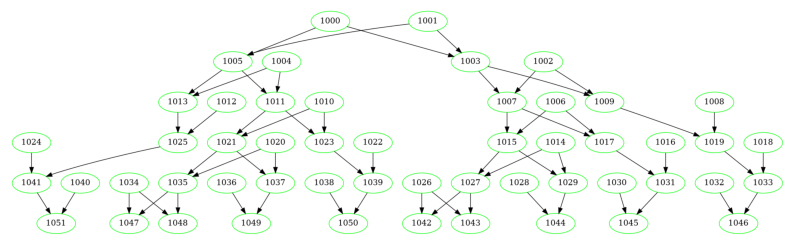

In [71]:
# Create a PyGraphviz graph
A = pgv.AGraph(directed=True)

# Add nodes and edges to the PyGraphviz graph
for node in true_graph.nodes():
    A.add_node(node)
    if node in [individual_to_bonsai.get(individual_id, individual_id) for individual_id in target_community_individual_ids]:
        A.get_node(node).attr['color'] = 'green'
    else:
        A.get_node(node).attr['color'] = 'white'

for edge in true_graph.edges():
    parent, child = edge
    A.add_edge(parent, child)

# Set Graphviz layout options
A.layout(prog='dot')

# Save and display the graph
graph_filename = f"{results_directory}/true_graph_target_community.png"
A.draw(graph_filename, format='png')

# Load and display the image
img = mpimg.imread(graph_filename)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

How does Bonsai compare to the ground truth?

## Exploring Bonsai

In [ ]:
# 1. Basic pedigree construction with different parameters
from utils.bonsaitree.bonsaitree.v3 import bonsai, constants

# Try building with different minimum segment lengths
up_dict_log_like_list_7cm = bonsai.build_pedigree(
    bio_info=filtered_bioinfo,
    unphased_ibd_seg_list=filtered_ibd_seg_list_v1,
    min_seg_len=7  # More stringent minimum segment length
)

# Try with restricted connections
up_dict_log_like_list_restricted = bonsai.build_pedigree(
    bio_info=filtered_bioinfo,
    unphased_ibd_seg_list=filtered_ibd_seg_list_v1,
    min_seg_len=3,
    restrict_connection_points=True
)

print(f"Number of pedigrees with 3cM threshold: {len(up_dict_log_like_list)}")
print(f"Number of pedigrees with 7cM threshold: {len(up_dict_log_like_list_7cm)}")
print(f"Number of pedigrees with restricted connections: {len(up_dict_log_like_list_restricted)}")

In [73]:
# 2. Examine pedigree likelihood differences
if len(up_dict_log_like_list) > 1:
    for i, (pedigree, log_like) in enumerate(up_dict_log_like_list):
        print(f"Pedigree {i+1} log likelihood: {log_like}")
        
    # Calculate likelihood ratio between best and second best
    if len(up_dict_log_like_list) >= 2:
        best_ll = up_dict_log_like_list[0][1]
        second_best_ll = up_dict_log_like_list[1][1]
        likelihood_ratio = np.exp(best_ll - second_best_ll)
        print(f"Likelihood ratio between best and second-best pedigree: {likelihood_ratio:.2f}")

Pedigree 1 log likelihood: -18203.296223544945
Pedigree 2 log likelihood: -18203.296223544945
Pedigree 3 log likelihood: -18203.296223544945
Likelihood ratio between best and second-best pedigree: 1.00


In [74]:
# 4. Analyze the top pedigree from Bonsai
if up_dict_log_like_list:
    top_pedigree = up_dict_log_like_list[0][0]
    
    # Count individuals by type
    real_individuals = [node for node in top_pedigree.keys() if isinstance(node, int) and node > 0]
    inferred_ancestors = [node for node in top_pedigree.keys() if isinstance(node, int) and node < 0]
    
    print(f"Top pedigree has {len(real_individuals)} real individuals")
    print(f"Top pedigree has {len(inferred_ancestors)} inferred ancestors")
    
    # Analyze pedigree depth (maximum generations)
    max_depth = 0
    for node in real_individuals:
        depth = 0
        current = node
        while current in top_pedigree and top_pedigree[current]:
            parent = list(top_pedigree[current].keys())[0]  # Get first parent
            current = parent
            depth += 1
        max_depth = max(max_depth, depth)
    
    print(f"Maximum depth in the pedigree: {max_depth} generations")

Top pedigree has 52 real individuals
Top pedigree has 26 inferred ancestors
Maximum depth in the pedigree: 4 generations


In [ ]:
# 5. Find potential siblings in the pedigree
def find_siblings(pedigree):
    # Group children by their parents
    parent_to_children = {}
    for child, parents in pedigree.items():
        if not parents:  # Skip nodes with no parents
            continue
        
        # Convert parents dict to a frozenset for use as dictionary key
        parent_key = frozenset(parents.keys())
        if parent_key not in parent_to_children:
            parent_to_children[parent_key] = []
        parent_to_children[parent_key].append(child)
    
    # Return sibling groups (only those with at least 2 siblings)
    sibling_groups = [children for children in parent_to_children.values() if len(children) >= 2]
    return sibling_groups

if up_dict_log_like_list:
    top_pedigree = up_dict_log_like_list[0][0]
    sibling_groups = find_siblings(top_pedigree)
    
    print(f"Found {len(sibling_groups)} sibling groups:")
    for i, group in enumerate(sibling_groups):
        real_siblings = [s for s in group if isinstance(s, int) and s > 0]
        print(f"Group {i+1}: {real_siblings}")

In [ ]:
# 6. Compare multiple communities using Bonsai
def compare_communities(communities, bioinfo, ibd_seg_list):
    results = {}
    
    for i, community in enumerate(communities[:3]):  # Compare first 3 communities
        print(f"Analyzing community {i+1} with {len(community)} members")
        
        # Filter bioinfo and IBD segments for this community
        community_bioinfo = [info for info in bioinfo if info['genotype_id'] in community]
        
        community_ibd = [
            seg for seg in ibd_seg_list
            if seg[0] in community and seg[1] in community
        ]
        
        # Run Bonsai
        up_dict_log_like_list = bonsai.build_pedigree(
            bio_info=community_bioinfo,
            unphased_ibd_seg_list=community_ibd,
            min_seg_len=3
        )
        
        if up_dict_log_like_list:
            top_pedigree = up_dict_log_like_list[0][0]
            top_likelihood = up_dict_log_like_list[0][1]
            
            results[i] = {
                "size": len(community),
                "pedigree": top_pedigree,
                "likelihood": top_likelihood,
                "real_individuals": len([n for n in top_pedigree.keys() if isinstance(n, int) and n > 0]),
                "inferred_ancestors": len([n for n in top_pedigree.keys() if isinstance(n, int) and n < 0])
            }
    
    return results

compare_communities(communities_v2, bioinfo, unphased_ibd_seg_list)

In [75]:
# 7. Analyze specific relationships in the pedigree
def analyze_relationship(pedigree, id1, id2):
    """Find the relationship between two individuals in the pedigree"""
    
    # Find path from id1 to root
    path1 = []
    current = id1
    while current in pedigree and pedigree[current]:
        parent = list(pedigree[current].keys())[0]  # Get first parent
        path1.append((current, parent))
        current = parent
    
    # Find path from id2 to root
    path2 = []
    current = id2
    while current in pedigree and pedigree[current]:
        parent = list(pedigree[current].keys())[0]  # Get first parent
        path2.append((current, parent))
        current = parent
    
    # Find common ancestor
    common_ancestors = set([p for _, p in path1]) & set([p for _, p in path2])
    if not common_ancestors:
        return "No relationship found"
    
    # Find closest common ancestor
    degrees = {}
    for ancestor in common_ancestors:
        degree1 = [p for _, p in path1].index(ancestor)
        degree2 = [p for _, p in path2].index(ancestor)
        degrees[ancestor] = (degree1, degree2)
    
    closest = min(degrees.items(), key=lambda x: sum(x[1]))
    ancestor, (deg1, deg2) = closest
    
    # Interpret relationship
    if deg1 == 0 and deg2 > 0:
        return f"{id1} is an ancestor of {id2}, {deg2} generations removed"
    elif deg2 == 0 and deg1 > 0:
        return f"{id2} is an ancestor of {id1}, {deg1} generations removed"
    elif deg1 == 1 and deg2 == 1:
        return f"{id1} and {id2} are siblings"
    elif deg1 == 1 and deg2 == 2:
        return f"{id1} is an aunt/uncle of {id2}"
    elif deg1 == 2 and deg2 == 1:
        return f"{id2} is an aunt/uncle of {id1}"
    elif deg1 == 2 and deg2 == 2:
        return f"{id1} and {id2} are first cousins"
    else:
        return f"{id1} and {id2} are related with common ancestor {ancestor}, {deg1} and {deg2} generations removed"

# Example usage
if up_dict_log_like_list:
    top_pedigree = up_dict_log_like_list[0][0]
    
    # Find relationships between several pairs of individuals
    id_pairs = [(1000, 1003), (1005, 1007), (1010, 1015)]
    for id1, id2 in id_pairs:
        relationship = analyze_relationship(top_pedigree, id1, id2)
        print(f"Relationship between {id1} and {id2}: {relationship}")

Relationship between 1000 and 1003: 1000 is an ancestor of 1003, 1 generations removed
Relationship between 1005 and 1007: No relationship found
Relationship between 1010 and 1015: No relationship found


In [ ]:
# 8. Validate Bonsai pedigree against truth (if available)
def compare_to_truth(inferred_pedigree, truth_pedigree):
    """Compare the inferred pedigree to ground truth"""
    
    # Get all real individuals in both pedigrees
    inferred_real_ids = [id for id in inferred_pedigree.keys() if isinstance(id, int) and id > 0]
    truth_real_ids = [id for id in truth_pedigree.keys() if isinstance(id, int) and id > 0]
    
    common_ids = set(inferred_real_ids) & set(truth_real_ids)
    print(f"Common individuals: {len(common_ids)}")
    
    # Check parent-child relationships
    correct_relationships = 0
    incorrect_relationships = 0
    
    for child in common_ids:
        if child in inferred_pedigree and child in truth_pedigree:
            inferred_parents = set(inferred_pedigree[child].keys())
            truth_parents = set(truth_pedigree[child].keys())
            
            # In the inferred pedigree, parents are often inferred ancestors
            # So we need to trace up to find real parents for comparison
            
            # This is a simplified approach:
            if any(p in truth_parents for p in inferred_parents):
                correct_relationships += 1
            else:
                incorrect_relationships += 1
    
    print(f"Correctly inferred relationships: {correct_relationships}")
    print(f"Incorrectly inferred relationships: {incorrect_relationships}")
    
    accuracy = correct_relationships / (correct_relationships + incorrect_relationships) if (correct_relationships + incorrect_relationships) > 0 else 0
    print(f"Accuracy: {accuracy:.2%}")

compare_to_truth(top_pedigree, truth_pedigree)

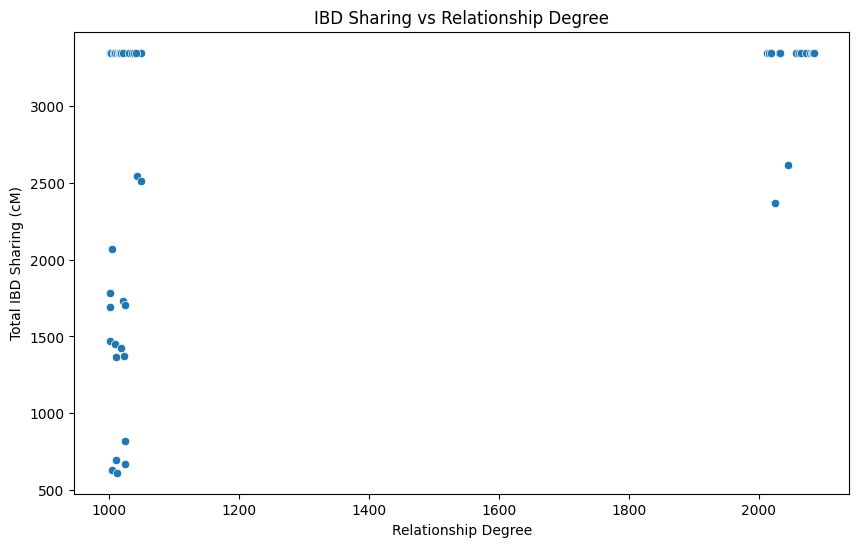

In [76]:
# 9. Plot IBD sharing vs relationship degree in the pedigree
import seaborn as sns

def plot_ibd_vs_relationship(pedigree, ibd_seg_list):
    """Plot the relationship between IBD sharing and relationship degree"""
    # Calculate total IBD sharing between all pairs
    ibd_sharing = {}
    for seg in ibd_seg_list:
        id1, id2 = seg[0], seg[1]
        pair = tuple(sorted([id1, id2]))
        ibd_sharing[pair] = ibd_sharing.get(pair, 0) + seg[6]  # Add segment length
    
    # Analyze relationships in the pedigree
    relationships = []
    ibd_amounts = []
    
    for pair, ibd_amount in ibd_sharing.items():
        id1, id2 = pair
        if id1 in pedigree and id2 in pedigree:
            relationship = analyze_relationship(pedigree, id1, id2)
            # Extract degree from relationship string (simplified)
            if "generations removed" in relationship:
                try:
                    degree = sum([int(s) for s in relationship.split() if s.isdigit()])
                    relationships.append(degree)
                    ibd_amounts.append(ibd_amount)
                except:
                    pass
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=relationships, y=ibd_amounts)
    plt.xlabel("Relationship Degree")
    plt.ylabel("Total IBD Sharing (cM)")
    plt.title("IBD Sharing vs Relationship Degree")
    plt.show()

plot_ibd_vs_relationship(top_pedigree, filtered_ibd_seg_list_v1)

In [77]:
# 10. Export pedigree in a standard format (e.g., GEDCOM-like)
def export_pedigree(pedigree, bioinfo, output_file):
    """Export the pedigree in a standard format"""
    # Create a mapping of ID to sex and age
    id_to_info = {info['genotype_id']: (info['sex'], info['age']) for info in bioinfo}
    
    with open(output_file, 'w') as f:
        f.write("# Exported Pedigree\n")
        f.write("# Format: ID Sex Age Parent1 Parent2\n")
        
        # Process all individuals, starting with real ones
        real_ids = sorted([id for id in pedigree.keys() if isinstance(id, int) and id > 0])
        inferred_ids = sorted([id for id in pedigree.keys() if isinstance(id, int) and id < 0])
        
        # Write real individuals first
        for id in real_ids:
            sex, age = id_to_info.get(id, ('U', 0))
            parents = list(pedigree.get(id, {}).keys())
            parent1 = parents[0] if len(parents) > 0 else 0
            parent2 = parents[1] if len(parents) > 1 else 0
            
            f.write(f"{id} {sex} {age} {parent1} {parent2}\n")
        
        # Then write inferred individuals
        for id in inferred_ids:
            # For inferred individuals, we can assume they're one generation older than their children
            children = [child for child, parents in pedigree.items() if id in parents]
            
            # Infer sex based on placement if possible
            inferred_sex = 'U'  # Unknown
            
            # Infer approximate age based on children's ages if possible
            inferred_age = 0
            for child in children:
                if child in id_to_info:
                    child_age = id_to_info[child][1]
                    if inferred_age == 0 or child_age + 20 < inferred_age:
                        inferred_age = child_age + 20
            
            parents = list(pedigree.get(id, {}).keys())
            parent1 = parents[0] if len(parents) > 0 else 0
            parent2 = parents[1] if len(parents) > 1 else 0
            
            f.write(f"{id} {inferred_sex} {inferred_age} {parent1} {parent2}\n")
    
    print(f"Pedigree exported to {output_file}")

# Example usage
if up_dict_log_like_list:
    export_pedigree(
        up_dict_log_like_list[0][0], 
        filtered_bioinfo, 
        os.path.join(results_directory, 'exported_pedigree.txt')
    )

Pedigree exported to /home/lakishadavid/computational_genetic_genealogy/results/exported_pedigree.txt
